In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
Image.LOAD_TRUNCATED_IMAGES = True

import timm
import torchvision.transforms as transforms

import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def predict_image(model, input_image):
    model.eval()
    with torch.no_grad():
        outputs = model(input_image)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        return predicted, confidence

def predict(model, image, transform):
    # image = Image.open(path)
    # image = image.convert("RGB")
    
    image_rgb = transform(image).unsqueeze(0)
    
    image_rgb = image_rgb.to(device)
    
    predicted_class, confidence = predict_image(model, image_rgb)
    pred = predicted_class.item()
    
    pred_result = class_mapping[str(pred)]
    return pred_result, confidence

In [3]:
class_mapping = {
            '0': '27_30',
            '1': '27_45',
            '2': '28',
            '3': '31'
        }

ad_class_mapping = {
            '27_30' : '0',
            '27_45' : '1',
            '28' : '2',
            '31' : '3'
        }

In [4]:
# 모델 불러오기 및 가중치 불러오기(inception, 1step활용)
model1 = timm.create_model('inception_v4', pretrained=False)
in_features = model1.last_linear.in_features
num_classes = 4
model1.last_linear = nn.Linear(in_features, num_classes)
model1.load_state_dict(torch.load('../../model/inception_v4_final.pth'))

model1 = model1.to(device)

resize = 299
transform1 = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor()
])

/tmp/ipykernel_3903042/2951103358.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('../../model/inception_v4_final.pth'))


In [5]:
# 모델 불러오기 및 가중치 불러오기 (mobilenet, 2step활용)
model2 = models.mobilenet_v3_small(pretrained=False)
num_classes = 4
model2.classifier[3] = nn.Linear(model2.classifier[3].in_features, num_classes)
model2.load_state_dict(torch.load('../../model/mobilenetv3_with_smote_multi_3.pth'))
model2 = model2.to(device)

transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

/home/dlit_ai/anaconda3/envs/pgn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dlit_ai/anaconda3/envs/pgn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3903042/2500341540.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will 

In [6]:
model3 = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=2)
model3.load_state_dict(torch.load('../../model/inception_resnet_v2_final_ll.pth'))

model3 = model3.to(device)

model4 = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=2)
model4.load_state_dict(torch.load('../../model_create/new_model/inception_resnet_v2_2class_2_final_ll.pth'))

model4 = model4.to(device)

resize = 299

/tmp/ipykernel_3903042/3169595673.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load('../../model/inception_resnet_v2_final_ll.pth'))
/tmp

In [35]:
# data_dir = '/home/dlit_ai/seohan/test_data/testdata_240227/'
# data_dir = '/home/dlit_ai/seohan_data/test_data/testdata_250109/'

# # 상위 폴더 내의 하위 폴더 목록을 가져옵니다.
# subdirectories = [os.path.join(data_dir, o) for o in os.listdir(data_dir) 
#                   if os.path.isdir(os.path.join(data_dir,o))]


parent_dirs = [
    '/home/dlit_ai/seohan_data/test_data/testdata_241218/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241219/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241220/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241221/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241223/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241224/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241225/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241226/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241227/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241228/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241230/',
    '/home/dlit_ai/seohan_data/test_data/testdata_241231/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250101/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250102/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250103/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250104/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250106/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250107/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250108/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250109/',
    '/home/dlit_ai/seohan_data/test_data/testdata_250110/',
]

all_subdirs = []
for dir_path in parent_dirs:
    subdirs = [os.path.join(dir_path, o) for o in os.listdir(dir_path)
               if os.path.isdir(os.path.join(dir_path, o))]
    all_subdirs.extend(subdirs)

y_test = []
predicted_class = []
wrong_label = []
predict2 = []
wrong_file = []
wrong_file1 = []

for subdir in all_subdirs:  
    files = [f for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]
    folder_label = subdir.split('/')[-1]
    su_folder_label = ad_class_mapping[folder_label]
    correct = folder_label
    
    for file in files:
        image = Image.open(subdir+'/'+file)
        image = image.convert("RGB")

        result, confidence = predict(model1, image, transform1)
        if correct != result:
            wrong_file1.append(file)
            wrong_label.append(ad_class_mapping[correct])
            predict2.append(ad_class_mapping[result])
            
        if (not correct.startswith('27') or not result.startswith('27')) and correct != result:
            result, confidence = predict(model2, image, transform2)
            
        if result.startswith('27'):
            result, confidence = predict(model3, image, transform1)
            # print(result, confidence)
            # if confidence < 0.9 or correct != result:
            #     result, confidence = predict(model4, image, transform1)
                # print(result, confidence)
                

        if correct != result :
            wrong_file.append(file)
        # if correct != result or confidence.item() < 0.85:
        #     print(file, correct, result, confidence)
        #     wrong_file1.append(file)
        #     wrong_label.append(ad_class_mapping[correct])
        #     if result in ['28', '31']:
        #         result, confidence = predict(model2, image, transform2)
                
        #     if result in ['27_30', '27_45']:
        #         result, confidence = predict(model3, image, transform1)

        #     predict2.append(ad_class_mapping[result])
        #     if correct != result :
        #         wrong_file.append(file)

        y_test.append(su_folder_label)
        predicted_class.append(ad_class_mapping[result])


In [36]:
set(predicted_class)

{'0', '1', '2', '3'}

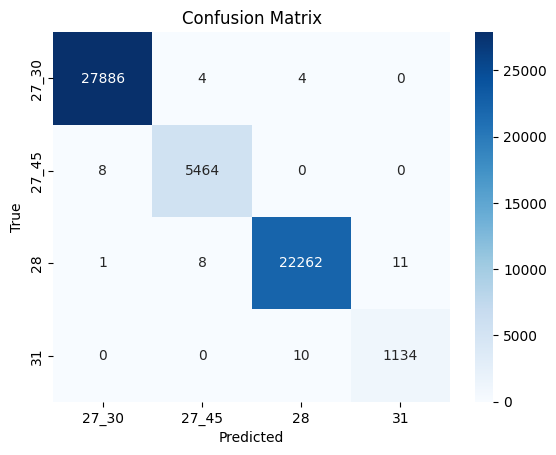

In [37]:
cm = confusion_matrix(y_test, predicted_class)
class_names = ['27_30', '27_45', '28', '31']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
wrong_file

['20241219_105248_131_49748-95270.bmp',
 '20241219_140434_253_49748-95273.bmp',
 '20241219_131356_123_49748-95273.bmp',
 '20241219_145224_326_49748-95273.bmp',
 '20241223_162802_907_49748-95273.bmp',
 '20241224_010029_370_49748-95270.bmp',
 '20241226_232520_4_49538-95285.bmp',
 '20241226_231959_10_49748-04310.bmp',
 '20241226_232216_13_49748-04310.bmp',
 '20241226_225039_1324_49748-95273.bmp',
 '20241226_225101_1325_49748-95273.bmp',
 '20241226_225208_1327_49748-95273.bmp',
 '20241226_225137_1326_49748-95273.bmp',
 '20241227_015850_47_49748-04310.bmp',
 '20241227_015018_41_49748-04310.bmp',
 '20241227_015316_43_49748-04310.bmp',
 '20241227_015534_45_49748-04310.bmp',
 '20241227_015642_46_49748-04310.bmp',
 '20241227_015455_44_49748-04310.bmp',
 '20241227_014443_37_49748-04310.bmp',
 '20250102_160453_232_49748-95270.bmp',
 '20250102_140653_16_49748-95270.bmp',
 '20250103_210648_20_49748-00310.bmp',
 '20250106_175750_104_49748-95270.bmp',
 '20250106_181026_139_49748-95270.bmp',
 '2025010

In [39]:
#1step에서 틀린것만
# cm = confusion_matrix(wrong_label, predict2)
# class_names = ['27_30', '27_45', '28', '31']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

In [48]:
# wrong_file1

['20241121_150446_621_49748-95270.bmp',
 '20241121_152127_655_49748-95270.bmp',
 '20241121_133309_477_49748-95270.bmp',
 '20241121_143150_590_49748-95270.bmp',
 '20241121_110214_258_49748-95270.bmp',
 '20241121_155625_738_49748-95270.bmp',
 '20241121_161523_781_49748-95270.bmp',
 '20241121_161145_771_49748-95270.bmp',
 '20241121_102626_193_49748-95270.bmp',
 '20241121_153529_690_49748-95270.bmp',
 '20241121_105747_252_49748-95270.bmp',
 '20241121_153352_687_49748-95270.bmp',
 '20241121_113004_317_49748-95270.bmp',
 '20241121_125851_90_49748-95273.bmp',
 '20241121_133921_195_49748-95273.bmp',
 '20241121_023255_623_49748-95273.bmp',
 '20241121_022047_600_49748-95273.bmp',
 '20241121_185926_854_49748-95273.bmp',
 '20241121_022200_602_49748-95273.bmp',
 '20241121_023218_622_49748-95273.bmp',
 '20241121_022654_612_49748-95273.bmp',
 '20241121_135451_230_49748-95273.bmp',
 '20241121_151946_415_49748-95273.bmp',
 '20241121_163639_598_49748-95273.bmp',
 '20241121_022124_601_49748-95273.bmp',
 

In [49]:
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score
# print(f1_score(y_test_cpu, predicted_class_cpu, average='micro'))
# print(accuracy_score(y_test_cpu, predicted_class_cpu))

NameError: name 'y_test_cpu' is not defined